# Matrix Factorization
- Train matrix factorization from scratch
- Matrix Factorization 코드는 [github](https://github.com/albertauyeung/matrix-factorization-in-python/blob/master/mf.py)을 참고했습니다.
- SGD를 사용한 matrix factorization 기법


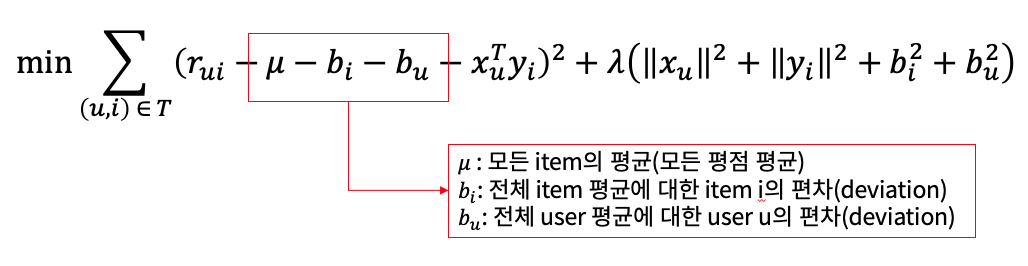

## Load Dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# 각자 작업 환경에 맞는 경로를 지정해주세요. Google Colab과 Jupyter환경에서 경로가 다를 수 있습니다.
path = './../data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [21]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)
train_df_large, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [45]:
train_df_small = train_df[:1000]

## Create Sparse Matrix

In [47]:
sparse_matrix = train_df_small.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

sparse_matrix = sparse_matrix.fillna(0)

# fill sparse matrix with average of movie ratings
# sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# # fill sparse matrix with average of user ratings
# sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [48]:
sparse_matrix_large = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix_large.index.name = 'movieId'

sparse_matrix_large = sparse_matrix_large.fillna(0)

In [49]:
sparse_matrix_large.shape

(8938, 610)

In [51]:
sparse_matrix.shape

(799, 347)

In [52]:
sparse_matrix = sparse_matrix.to_numpy()
# sparse_matrix_withmovie = sparse_matrix_withmovie.to_numpy()
sparse_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Implement Matrix Factorization

In [16]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        # epochs
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            # if (i+1) % 10 == 0:
            print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

## Train MF

- Large 모델

In [25]:
sparse_matrix_large = sparse_matrix_large.to_numpy()

In [30]:
sparse_matrix_large.shape

(8938, 610)

In [27]:
mf = MF(sparse_matrix_large, K=300, alpha=0.1, beta=0.01, iterations=20)

In [28]:
# large모델은 너무 sparse해서 학습이 안되고 exploding이 일어남.
training_process = mf.train()

C:\Users\user\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in multiply
C:\Users\user\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in multiply


Iteration: 1 ; error = nan
Iteration: 2 ; error = nan
Iteration: 3 ; error = nan
Iteration: 4 ; error = nan
Iteration: 5 ; error = nan
Iteration: 6 ; error = nan
Iteration: 7 ; error = nan
Iteration: 8 ; error = nan
Iteration: 9 ; error = nan
Iteration: 10 ; error = nan


KeyboardInterrupt: 

- Small 모델

In [53]:
sparse_matrix.shape

(799, 347)

In [54]:
mf = MF(sparse_matrix, K=300, alpha=0.1, beta=0.01, iterations=20)

In [55]:
training_process = mf.train()

Iteration: 1 ; error = 25.2224
Iteration: 2 ; error = 21.6049
Iteration: 3 ; error = 19.0578
Iteration: 4 ; error = 17.1316
Iteration: 5 ; error = 15.5637
Iteration: 6 ; error = 14.2348
Iteration: 7 ; error = 13.0652
Iteration: 8 ; error = 12.0317
Iteration: 9 ; error = 11.0928
Iteration: 10 ; error = 10.2210
Iteration: 11 ; error = 9.3900
Iteration: 12 ; error = 8.5967
Iteration: 13 ; error = 7.8337
Iteration: 14 ; error = 7.1154
Iteration: 15 ; error = 6.4376
Iteration: 16 ; error = 5.8197
Iteration: 17 ; error = 5.2630
Iteration: 18 ; error = 4.7672
Iteration: 19 ; error = 4.3313
Iteration: 20 ; error = 3.9401


In [56]:
mf.full_matrix()

array([[4.8754015 , 4.89171929, 4.54690658, ..., 3.9715581 , 3.73587857,
        4.12099628],
       [4.19459809, 4.20609229, 3.86613877, ..., 3.28928589, 3.07566621,
        3.42266545],
       [3.71650815, 3.72845859, 3.38877903, ..., 2.81191925, 2.59604529,
        2.94187096],
       ...,
       [4.1111034 , 4.12246372, 3.78268428, ..., 3.20589575, 2.98602441,
        3.34050431],
       [4.40458572, 4.41704133, 4.07652036, ..., 3.50002251, 3.2768849 ,
        3.64178576],
       [3.87604044, 3.88849596, 3.54768281, ..., 2.97089592, 2.75009449,
        3.11144372]])

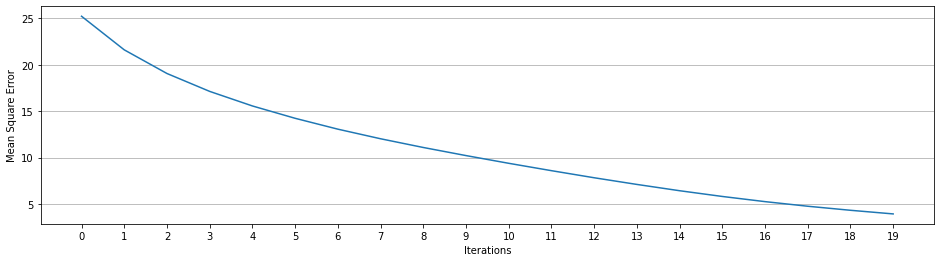

In [57]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

# Wrap-up Collaborative Filtering

## 1. Neighborhood-based Collaborative Filtering

### 1-1. Item-based
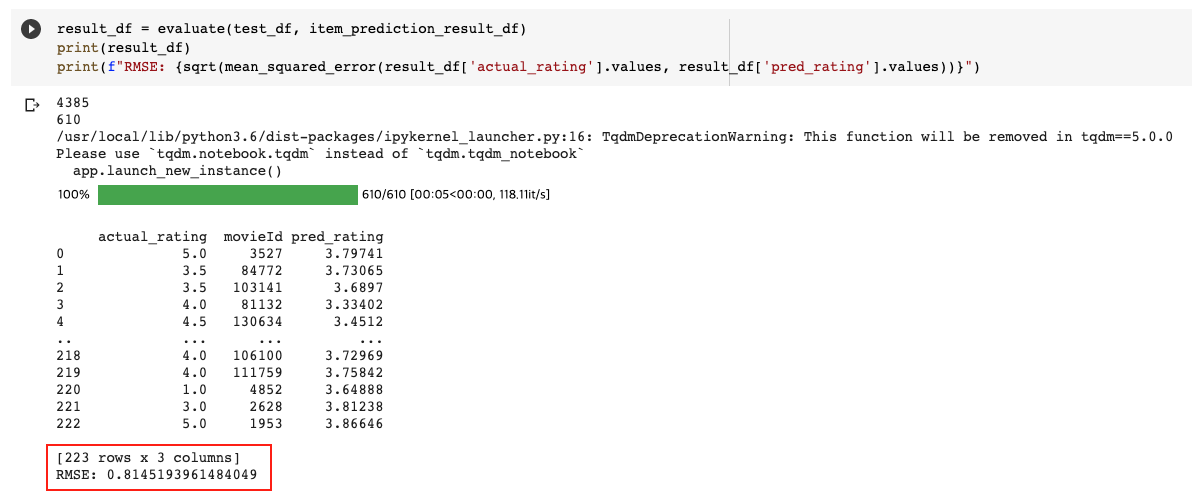


### 1-2. User-based
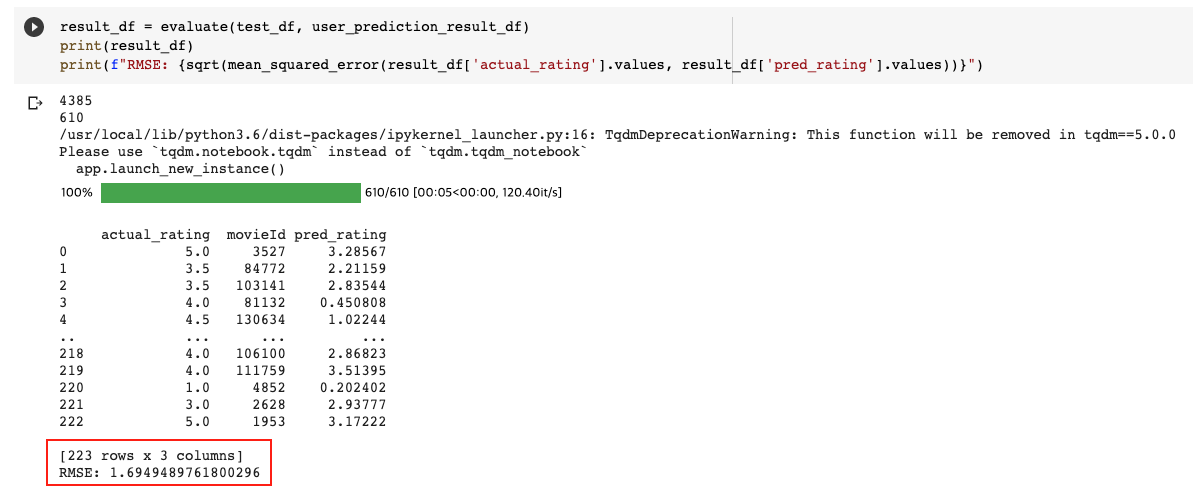

## Matrix Factorization with SVD, finding best k
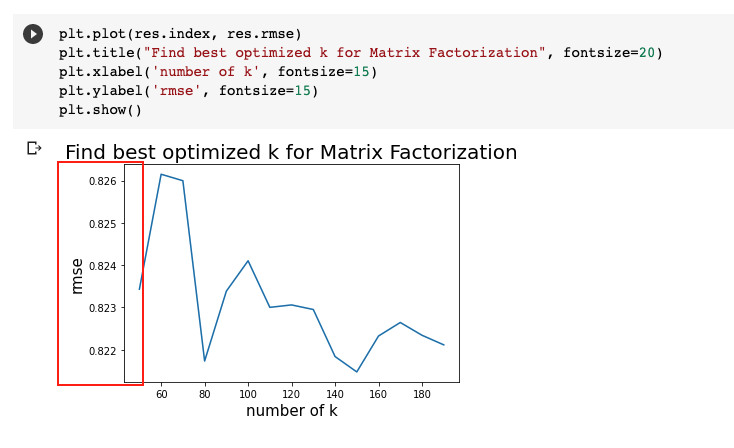

## Contents-based

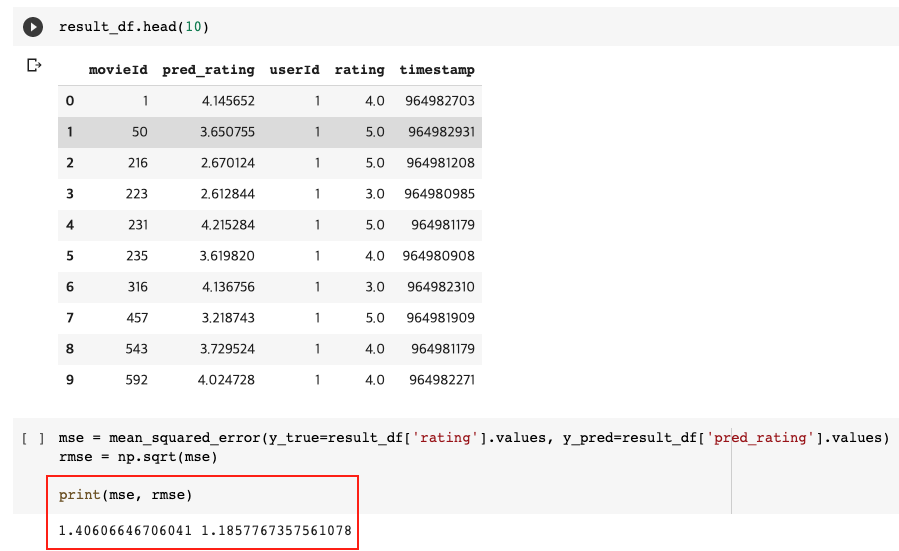